In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

df = pd.read_csv("cleansed.csv",index_col=0, keep_default_na=False,parse_dates=["date_added"])

df1 = df.copy()
df1

,resource_type,indicator,owner_name,rating,confidence,threat_assess_confidence,threat_assess_rating,date_added,Country,Architecture,Target,Tags
0,ADDRESSES,122.177.174.216,Blocklist.de SSH IPs,4.0,4,4.0,4.0,2021-03-30 09:15:03,,,,
1,HOSTS,scurityidlockinfowellsfargo.com,CAL Finance-themed NRDs,3.0,61,62.0,3.0,2022-05-11 00:00:00,,,,Host.RecentlyRegistered.7D;
2,HOSTS,down.flash-plays.com,Firebog Prigent Malware Domains,3.0,75,75.0,3.0,2021-06-03 02:29:12,,,,
3,FILES,"{'md5': '222BFA268954D953348A11FAEC0E011F', 's...",MalShare Daily Malware List,3.0,69,69.0,3.0,2021-06-23 15:15:04,,,,
4,FILES,"{'md5': 'BE75224E48976EB4BA3FAEB9D0D14A5F', 's...",MalShare Daily Malware List,3.0,69,69.0,3.0,2021-11-19 05:00:00,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
4249748,URLS,http://178.175.117.56:53099/Mozi.a,abuse.ch URLHaus,3.0,65,65.0,3.0,2021-04-29 12:05:20,,,,elf;malware_download;Mozi;
4249749,URLS,http://182.59.42.217:40443/Mozi.m,abuse.ch URLHaus,3.0,65,65.0,3.0,2020-11-10 11:56:02,,,,elf;malware_download;Mozi;
4249750,URLS,http://sanavitawellnesscoaching.com/b/auth/log...,OpenPhish,3.0,0,0.0,3.0,2019-11-19 14:51:38,,,,
4249751,URLS,http://182.121.147.99:51686/Mozi.m,abuse.ch URLHaus,3.0,65,65.0,3.0,2021-05-07 01:05:09,,,,elf;malware_download;Mozi;


In [2]:
df1 = df1[["resource_type","indicator","owner_name","rating","confidence","date_added","Tags"]]

df1 = df1.join(pd.get_dummies(df1.resource_type, prefix='type'))

# Convert to datetime
df2 = df1.copy()
df2['count'] = ' '

# I think this should NOT be mean but another aggregate function... maybe variance? No... max?

# df3 = df2.groupby(pd.Grouper(key='date_added', freq='1W'))["rating"].mean().reset_index()
# df4 = df2.groupby(pd.Grouper(key='date_added', freq='1W'))["confidence"].mean().reset_index()
# df5 = df2.groupby(pd.Grouper(key='date_added', freq='1W'))[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']].sum().reset_index()
df2 = df2.groupby(pd.Grouper(key='date_added', freq='1D'))["count"].count().reset_index()

# df2['avg_rating'] = df3['rating']
# df2['avg_confidence'] = df4['confidence']
# df2[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']] = df5[['type_ADDRESSES','type_CUSTOM INDICATORS','type_EMAIL ADDRESSES','type_FILES','type_HOSTS','type_URLS']]
mean = df2["count"].mean()
df2

,date_added,count
0,2017-09-08,25533
1,2017-09-09,24
2,2017-09-10,11
3,2017-09-11,9
4,2017-09-12,20
...,...,...
1712,2022-05-17,12131
1713,2022-05-18,7400
1714,2022-05-19,10883
1715,2022-05-20,6678


In [3]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = pd.DataFrame(df2['count']).mean()
training_std = pd.DataFrame(df2['count']).std()
df_training_value = (pd.DataFrame(df2['count']) - training_mean) / training_std
print("Number of training samples:", len(df_training_value))
df_training_value.shape

Number of training samples: 1717


(1717, 1)

In [4]:
TIME_STEPS = 8

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# x_train = df_training_value
# x_train.shape

Training input shape:  (1710, 8, 1)


In [5]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 32)             256       
                                                                 
 dropout (Dropout)           (None, 4, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 16)             3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4, 16)            1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 4, 16)             0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 8, 32)            3616      
 ranspose)                                              

In [6]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
13/13 [==============================] - 2s 49ms/step - loss: 0.8455 - val_loss: 1.7976
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.7293 - val_loss: 1.5782
Epoch 3/50
13/13 [==============================] - 0s 5ms/step - loss: 0.5188 - val_loss: 1.0936
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.3878 - val_loss: 1.0452
Epoch 5/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3596 - val_loss: 1.0169
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.3398 - val_loss: 0.9678
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 0.3219 - val_loss: 0.9184
Epoch 8/50
13/13 [==============================] - 0s 7ms/step - loss: 0.3035 - val_loss: 0.8526
Epoch 9/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2897 - val_loss: 0.7623
Epoch 10/50
13/13 [==============================] - 0s 8ms/step - loss: 0.2625 - val_loss: 0.6941
Epoch 11/50
13/13 

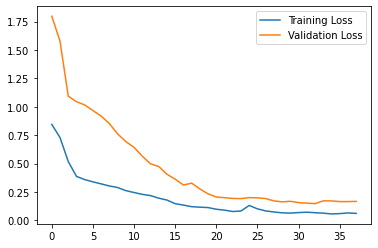

In [7]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

54/54 [==============================] - 0s 1ms/step


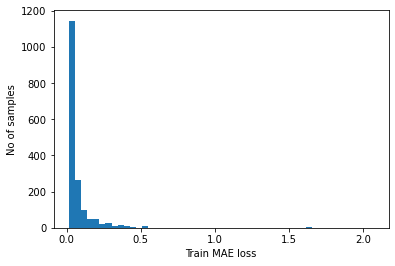

Reconstruction error threshold:  0.2068329720750926


In [37]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)/10
print("Reconstruction error threshold: ", threshold)

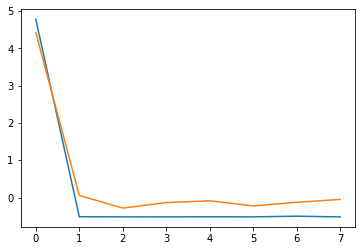

(1710, 8, 1)

In [38]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()
x_train.shape

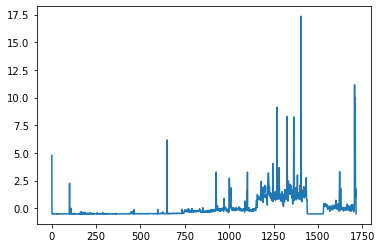

Test input shape:  (1710, 8, 1)
54/54 [==============================] - 0s 1ms/step


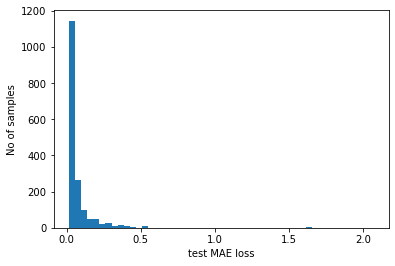

Number of anomaly samples:  118
Indices of anomaly samples:  (array([   0,   94,   95,   96,   97,   98,   99,  100,  642,  643,  644,
        645,  646,  647,  648,  649,  926, 1006, 1007, 1008, 1096, 1097,
       1098, 1099, 1100, 1101, 1102, 1185, 1190, 1212, 1213, 1214, 1215,
       1216, 1217, 1218, 1219, 1220, 1221, 1239, 1242, 1243, 1244, 1245,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1274, 1275, 1277,
       1278, 1279, 1281, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327,
       1328, 1329, 1331, 1349, 1357, 1358, 1359, 1360, 1361, 1362, 1363,
       1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1428, 1430, 1431,
       1432, 1433, 1434, 1435, 1436, 1437, 1438, 1616, 1617, 1618, 1619,
       1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1700, 1701,
       1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709], dtype=int64),)


In [39]:
df_test_value = df_training_value
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [40]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [41]:
df_subset = df2.iloc[anomalous_data_indices]
# fig, ax = plt.subplots()
# df2.plot(legend=False, ax=ax)
# df_subset.plot(legend=False, ax=ax, color="r")
# plt.show()

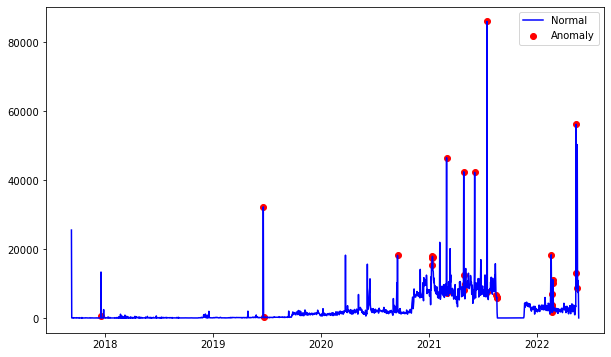

Number of anomaly samples:  30


In [42]:
fig, ax = plt.subplots(figsize=(10,6))

a = df_subset #anomaly

ax.plot(df2['date_added'], df2['count'], color='blue', label = 'Normal')
ax.scatter(a['date_added'],a['count'], color='red', label = 'Anomaly')

plt.legend()
plt.show();
print("Number of anomaly samples: ", a.shape[0])

In [45]:
df2.to_csv('AutoEncoderAnomaly.csv')
df2

,date_added,count
0,2017-09-08,25533
1,2017-09-09,24
2,2017-09-10,11
3,2017-09-11,9
4,2017-09-12,20
...,...,...
1712,2022-05-17,12131
1713,2022-05-18,7400
1714,2022-05-19,10883
1715,2022-05-20,6678


In [44]:
# import numpy as np
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.utils.data import generate_data

